In [1]:
from anndata import AnnData
from main import IMAAE
from utils import data_preprocess,compute_asw,compute_ARI_NMI
import scanpy as sc
import numpy as np
import time
import os
import pandas as pd
from matplotlib.pyplot import rc_context

## Initialization

In [2]:
sc.set_figure_params(dpi=100)
sc.settings.verbosity = 1
sc.logging.print_header()

input_dir = '../data'
res_dir = 'result'
method_name = 'IMAAE'
data_name = 'panc'
data_path = os.path.join(input_dir,data_name+'.loom')
save_loom_path = os.path.join(res_dir,method_name+'_'+data_name+'.loom')
save_batch_png_path = '_'+method_name+'_'+data_name+'_batch.png'
save_celltype_png_path ='_'+method_name+'_'+data_name+'_celltype.png'

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.5.2 pandas==1.2.3 scikit-learn==1.0.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


## scAAE

In [3]:
start_time = time.time()

adata = sc.read_loom(data_path,sparse = False)
adata.obs['batch'] = adata.obs['batch'].astype('category')

In [4]:
adata.X = np.float32(np.int32(adata.X))
adata = data_preprocess(adata)

/opt/anaconda3/envs/zcg-TieNet-py37/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/opt/anaconda3/envs/zcg-TieNet-py37/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


PreProcess Done.


In [5]:
out,latent= IMAAE(adata,n_epochs=100,batch_size=1024,n_critic=2)

end_time = time.time()
print("Time consuming: "+str(end_time-start_time))

[0 4 1 2 3]
(14865, 2000)
14865
Encoder(
  (relu): ReLU(inplace=True)
  (enc): Sequential(
    (0): Linear(in_features=2000, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): Linear(in_features=1000, out_features=500, bias=True)
    (4): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Mish()
    (6): Linear(in_features=500, out_features=250, bias=True)
    (7): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Mish()
  )
  (mu_enc): Linear(in_features=250, out_features=250, bias=True)
  (var_enc): Linear(in_features=250, out_features=250, bias=True)
)
The number of Encoder' parameters: 2755750
Decoder(
  (relu): ReLU(inplace=True)
  (decoder): Sequential(
    (0): Linear(in_features=250, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2

Epoch [99/100]: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s, AE_loss=39.9, Dz_loss=-.0637, Gz_loss=0.125] 


Time consuming: 75.00861144065857


## Evaluation

In [6]:
res = AnnData(out,adata.obs)
# res.write_loom(save_loom_path,write_obsm_varm=True)
sc.pp.neighbors(res)
sc.tl.umap(res)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'ClusterName' as categorical
... storing 'celltype' as categorical


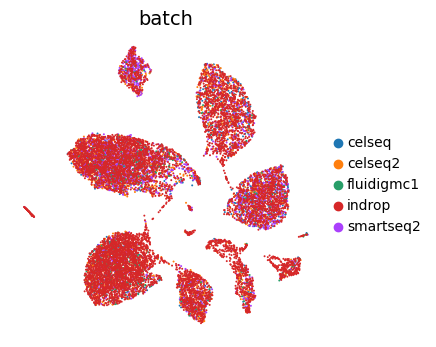

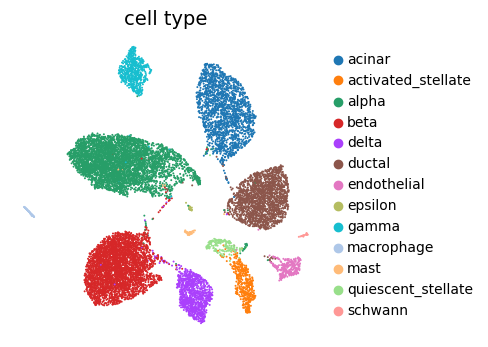

In [7]:
sc.pl.umap(res,color=['batch'], add_outline=False,legend_fontsize=10,frameon=False,title='batch',save=save_batch_png_path)
sc.pl.umap(res,color=['celltype'], add_outline=False,legend_fontsize=10,frameon=False,title='cell type',save=save_celltype_png_path)

In [9]:
arr = res.obsm['X_pca']
batch_label = res.obs['batch'].tolist()
cell_label = res.obs['celltype'].tolist()

asw_batch_score, asw_celltype_score = compute_asw(arr, batch_label, cell_label)
print("ASW score：")
print(asw_batch_score,asw_celltype_score)

batch_ARI, cell_ARI,batch_NMI,cell_NMI = compute_ARI_NMI(res)
print("ARI score：")
print(batch_ARI, cell_ARI)

print("NMI score：")
print(batch_NMI, cell_NMI)

matrix_path = os.path.join(res_dir,method_name+'_'+data_name+'_matrix.csv')
meta_path = os.path.join(res_dir,method_name+'_'+data_name+'_meta.csv')
lisi_path = os.path.join(res_dir,method_name+'_'+data_name+'_lisi.csv')

np.savetxt(matrix_path, res.obsm['X_pca'], delimiter=',')
data = {'batch':res.obs.batch.tolist(), 'celltype':res.obs.celltype.tolist()}
df = pd.DataFrame(data)
df.to_csv(meta_path,index=False)

process_args = "~/.conda/envs/zcg/bin/Rscript LISI.R "+matrix_path+" "+meta_path+" "+lisi_path
print("LISI score：")
print(os.popen(process_args).read())

ASW score：
-0.18044466 0.7439725
ARI score：
0.008903758744939051 0.9139528766981976
NMI score：
0.02935583413522187 0.9249935634761751
LISI score：

